In [2]:
import numpy as np
from process_nwb.linenoise_notch import apply_linenoise_notch
from process_nwb.resample import resample
import matplotlib.pyplot as plt
from scipy.ndimage.filters import median_filter

from scipy.spatial.distance import cosine

# Line noise

In [44]:
def gen_data(t, fs, mean=0., norm=True, noise_std=0.):
    if t.ndim == 1:
        t = t[:, np.newaxis]
    X = np.zeros_like(t)
    X = np.zeros_like(t)
    for f  in fs:
        X += np.sin(2. * np.pi * f * t)
    if noise_std > 0.:
        X += np.random.randn(*X.shape) * noise_std
    if norm:
        X /= X.std()
    X += mean
    return X

In [55]:
dt = 100.00 # seconds
rate = 1000. # Hz
df = 0.
t = np.linspace(0, dt, int(dt * rate))
n_harmonics = int((rate / 2) // 60)
fs = [(ii + 1) * (60. + df) for ii in range(n_harmonics)]

X = gen_data(t, fs, 5., noise_std=0.1)

In [56]:
Xp = apply_linenoise_notch(X, rate, fft=True)

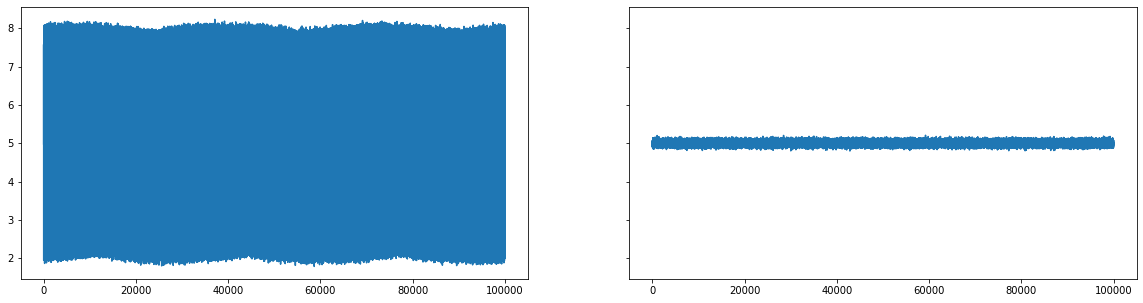

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
axes[0].plot(X[:, 0])
axes[1].plot(Xp[:, 0])

# Resample

In [58]:
dt = 50. # seconds
fs = np.linspace(1, 20.1, 5.33)

rate = 400. # Hz
t = np.linspace(-dt/2., dt/2., int(dt * rate))[:, np.newaxis]
X = gen_data(t, fs, 2.)

new_rate = 211. # Hz
t_new = np.linspace(-dt/2., dt/2., int(dt * new_rate))
X_new_rate =gen_data(t_new, fs, 2.)

Xds = resample(X, new_rate, rate)
Xds2 = resample(X, new_rate, rate, real=False)
Xdsm = (Xds + resample(X[::-1], new_rate, rate)[::-1]) / 2.
Xds2m = (Xds2 + resample(X[::-1], new_rate, rate, real=False)[::-1]) / 2.

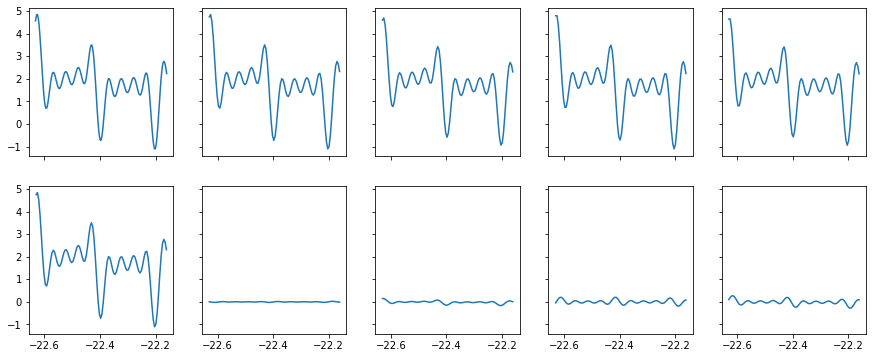

In [60]:
start = 500
n_pts = 100
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)

sl = slice(int(start*rate/new_rate), int((start+n_pts)*rate/new_rate))
axes[0, 0].plot(t[sl], X[sl, 0])
sl = slice(start, start+n_pts)
axes[1, 0].plot(t_new[sl], X_new_rate[sl, 0])

axes[0, 1].plot(t_new[sl], Xds[sl, 0])
axes[1, 1].plot(t_new[sl], (X_new_rate - Xds)[sl, 0])

axes[0, 2].plot(t_new[sl], Xds2[sl, 0])
axes[1, 2].plot(t_new[sl], (X_new_rate - Xds2)[sl, 0])

axes[0, 3].plot(t_new[sl], Xdsm[sl, 0])
axes[1, 3].plot(t_new[sl], (X_new_rate - Xdsm)[sl, 0])

axes[0, 4].plot(t_new[sl], Xds2m[sl, 0])
axes[1, 4].plot(t_new[sl], (X_new_rate - Xds2m)[sl, 0])

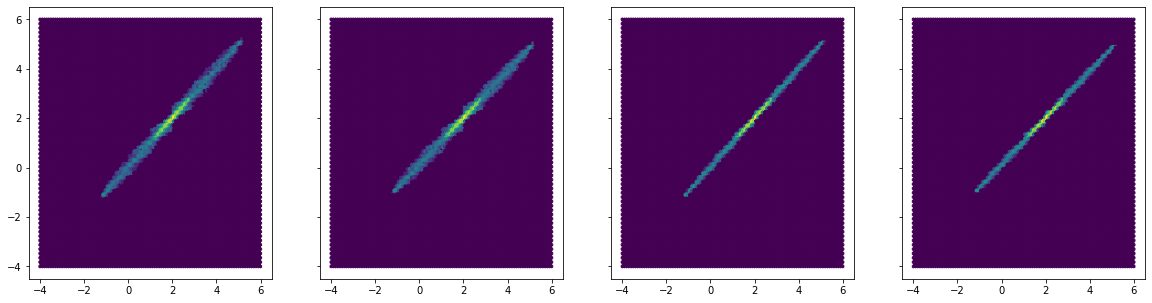

In [61]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True, sharex=True)
axes[0].hexbin(X_new_rate.ravel(), Xds.ravel(), gridsize=100, bins='log', extent=[-4, 6, -4, 6])
axes[1].hexbin(X_new_rate.ravel(), Xds2.ravel(), gridsize=100, bins='log', extent=[-4, 6, -4, 6])
axes[2].hexbin(X_new_rate.ravel(), Xdsm.ravel(), gridsize=100, bins='log', extent=[-4, 6, -4, 6])
axes[3].hexbin(X_new_rate.ravel(), Xds2m.ravel(), gridsize=100, bins='log', extent=[-4, 6, -4, 6])

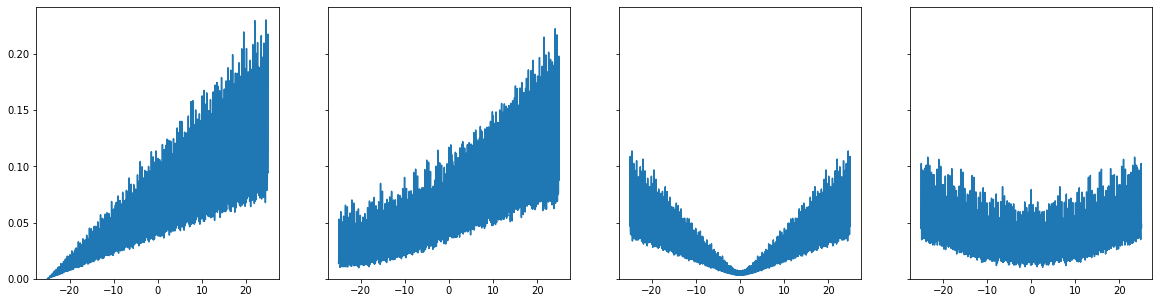

In [62]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True, sharex=True)
axes[0].plot(t_new, median_filter(abs(X_new_rate[:, 0] - Xds[:, 0]), size=20))
axes[1].plot(t_new, median_filter(abs(X_new_rate[:, 0] - Xds2[:, 0]), size=20))
axes[2].plot(t_new, median_filter(abs(X_new_rate[:, 0] - Xdsm[:, 0]), size=20))
axes[3].plot(t_new, median_filter(abs(X_new_rate[:, 0] - Xds2m[:, 0]), size=20))
for ax in axes.ravel():
    ax.set_ylim(0, None)

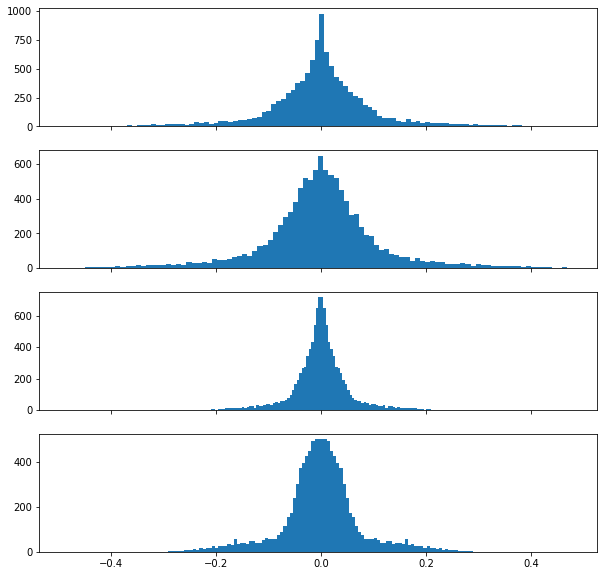

In [65]:
fig, axes = plt.subplots(4, sharex=True, figsize=(10, 10))
_ = axes[0].hist((X_new_rate-Xds).ravel(), bins=100)
_ = axes[1].hist((X_new_rate-Xds2).ravel(), bins=100)
_ = axes[2].hist((X_new_rate-Xdsm).ravel(), bins=100)
_ = axes[3].hist((X_new_rate-Xds2m).ravel(), bins=100)

In [64]:
print(cosine(X_new_rate.ravel(), Xds.ravel()))
print(cosine(X_new_rate.ravel(), Xds2.ravel()))
print(cosine(X_new_rate.ravel(), Xdsm.ravel()))
print(cosine(X_new_rate.ravel(), Xds2m.ravel()))

0.0010329614299983136
0.001211208621687554
0.00026001522737595373
0.0005025082127791958
